In [1]:
import os
import numpy as np
import keras
from keras import layers
from tensorflow import data as tf_data
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import pandas as pd
from collections import Counter
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    roc_auc_score, confusion_matrix, classification_report
)

%matplotlib inline

# Load the data: the Cats vs Dogs dataset
## Raw data download
### First, let's download the 786M ZIP archive of the raw data:

In [2]:
# !curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip

In [3]:
# !unzip -q kagglecatsanddogs_5340.zip
# !ls

In [4]:
!ls /kaggle/working/PetImages

Cat  Dog


## Filter out corrupted images

##### When working with lots of real-world image data, corrupted images are a common occurence. Let's filter out badly-encoded images that do not feature the string "JFIF" in their header.

In [5]:
image_folder="/kaggle/working/PetImages"
num_skipped=0
for folder_name in ("Cat","Dog"):
    folder_path=os.path.join(image_folder,folder_name)
    for fname in os.listdir(folder_path):
        fpath=os.path.join(folder_path,fname)
        try:
            fobj=open(fpath,"rb")
            is_jfif=b"JFIF" in fobj.peek(10)
        finally:
            fobj.close()
        if not is_jfif:
            num_skipped+=1
            os.remove(fpath)

print(f"Deleted {num_skipped} images.")


Deleted 0 images.


# Generate a Dataset

In [6]:
image_size=(220,220)
batch_size=32
train_data,valid_data=keras.utils.image_dataset_from_directory(
    image_folder,validation_split=0.3,subset="both",seed=42,image_size=image_size,
    batch_size=batch_size
)

Found 23410 files belonging to 2 classes.
Using 16387 files for training.
Using 7023 files for validation.


# Load test dataset separately (from the same folder)

In [7]:
test_data = keras.utils.image_dataset_from_directory(
    image_folder,
    validation_split=0.2,  
    subset="validation",
    seed=42,
    image_size=image_size,
    batch_size=batch_size
)

Found 23410 files belonging to 2 classes.
Using 4682 files for validation.


# Calculate lengths

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


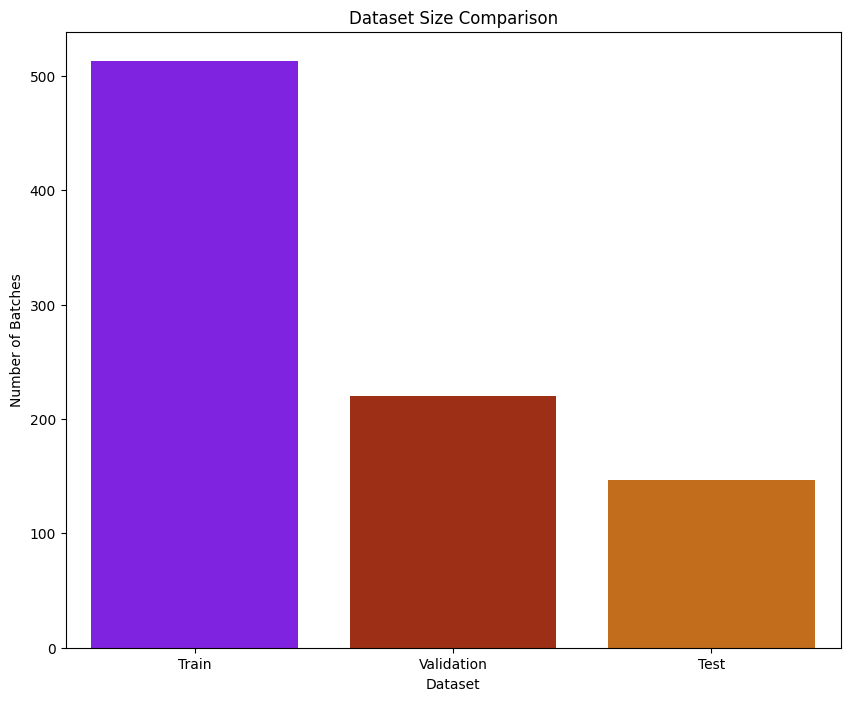

In [8]:

train_size = tf.data.experimental.cardinality(train_data).numpy()
valid_size = tf.data.experimental.cardinality(valid_data).numpy()
test_size = tf.data.experimental.cardinality(test_data).numpy()

# Create a dictionary for visualization
dataset_sizes = {"Train": train_size, "Validation": valid_size, "Test": test_size}

# Create a Seaborn bar chart
plt.figure(figsize=(10,8))
sns.barplot(x=list(dataset_sizes.keys()), y=list(dataset_sizes.values()), palette="gnuplot")
plt.xlabel("Dataset")
plt.ylabel("Number of Batches")
plt.title("Dataset Size Comparison")
plt.show()

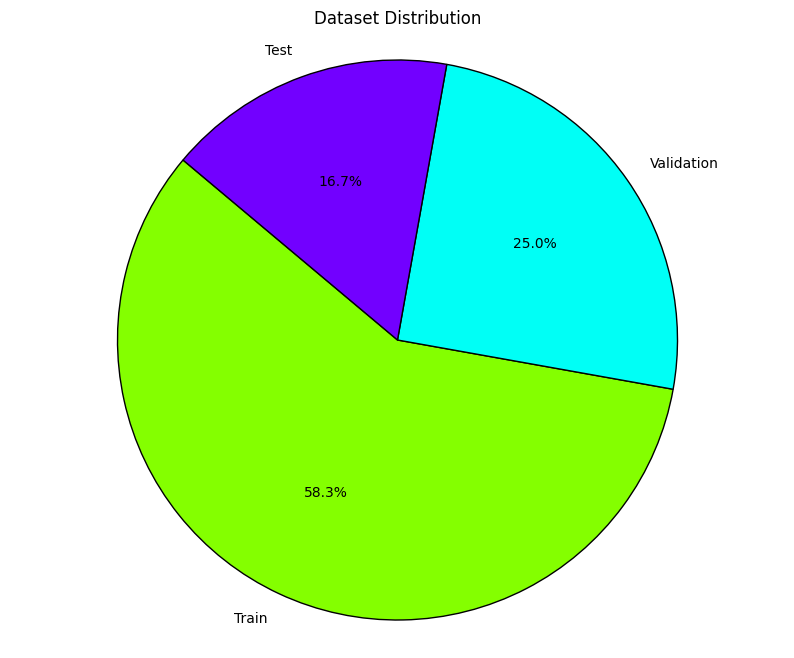

In [9]:
labels = ["Train", "Validation", "Test"]
sizes = [train_size, valid_size, test_size]
colors = sns.color_palette("hsv", 3)
plt.figure(figsize=(10,8))
plt.pie(sizes, labels=labels, autopct="%1.1f%%", colors=colors, startangle=140, wedgeprops={"edgecolor": "black"})
plt.title("Dataset Distribution")
plt.axis("equal")
plt.show()

# Compare Class Length

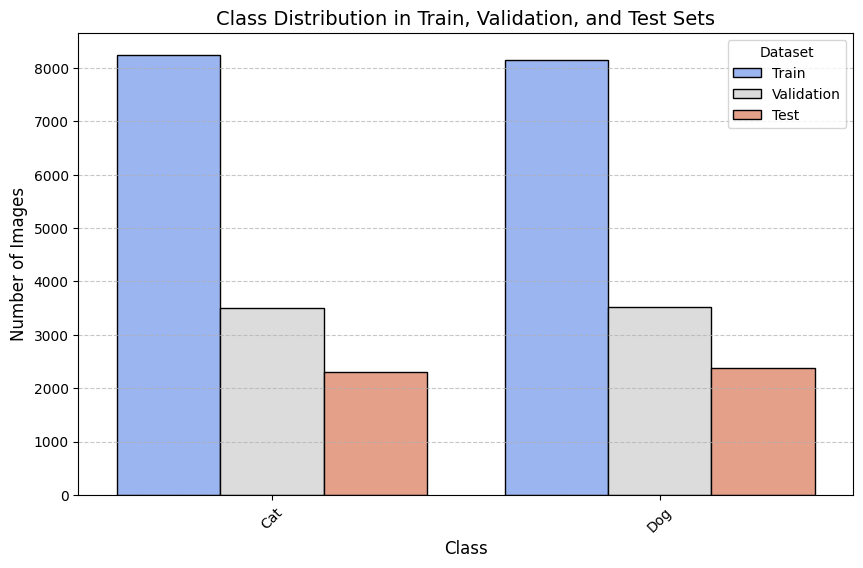

In [10]:

class_names = train_data.class_names
def count_classes(dataset):
    class_counts = Counter()
    for images, labels in dataset:
        class_counts.update(labels.numpy())  # Convert tensor to numpy
    return dict(class_counts)

# Get class distributions
train_counts = count_classes(train_data)
valid_counts = count_classes(valid_data)
test_counts = count_classes(test_data)

# Convert to lists
labels = class_names
train_values = [train_counts.get(i, 0) for i in range(len(class_names))]
valid_values = [valid_counts.get(i, 0) for i in range(len(class_names))]
test_values = [test_counts.get(i, 0) for i in range(len(class_names))]

df = pd.DataFrame({
    "Class": labels,
    "Train": train_values,
    "Validation": valid_values,
    "Test": test_values
})
df_long = df.melt(id_vars="Class", var_name="Dataset", value_name="Count")

plt.figure(figsize=(10, 6))
sns.barplot(data=df_long, x="Class", y="Count", hue="Dataset", palette="coolwarm", edgecolor="black")
plt.title("Class Distribution in Train, Validation, and Test Sets", fontsize=14)
plt.xlabel("Class", fontsize=12)
plt.ylabel("Number of Images", fontsize=12)
plt.xticks(rotation=45)
plt.legend(title="Dataset")
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.show()

In [11]:
df

Class  Train  Validation  Test
0   Cat   8245        3496  2310
1   Dog   8142        3527  2372

# Visualize the data from train data
### Here are the first 25 images in the training dataset.

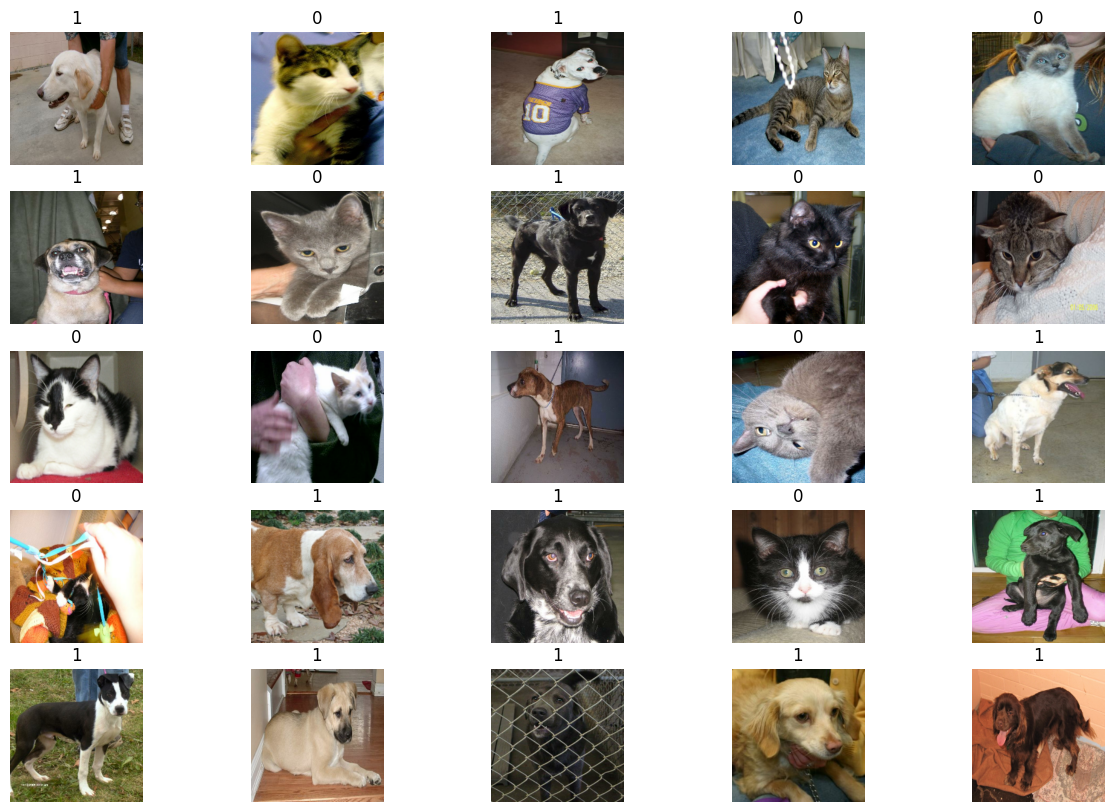

In [12]:
plt.figure(figsize=(15,10))
for image,label in train_data.take(1):
    for i in range(25):
        ax=plt.subplot(5,5,i+1)
        plt.imshow(np.array(image[i]).astype("uint8"))
        plt.title(int(label[i]))
        plt.axis("off")
    plt.show()

# visualize images from valid data

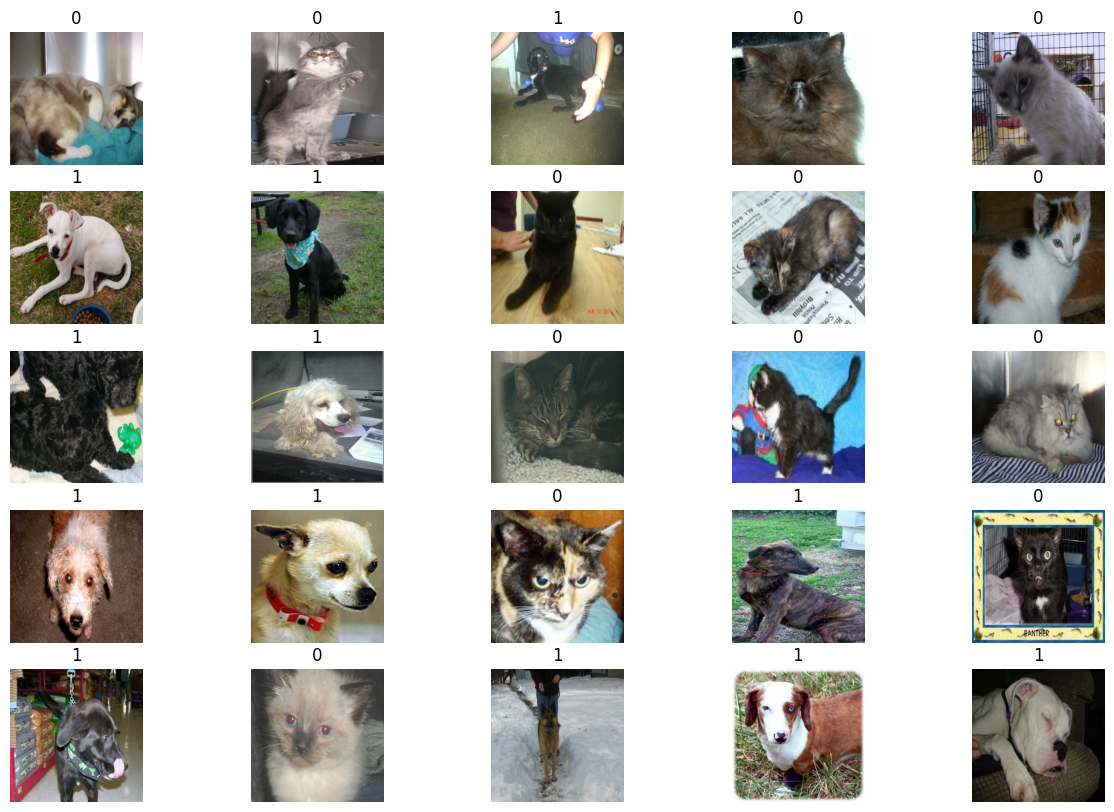

In [13]:
plt.figure(figsize=(15,10))
for image,label in valid_data.take(1):
    for i in range(25):
        ax=plt.subplot(5,5,i+1)
        plt.imshow(np.array(image[i]).astype("uint8"))
        plt.title(int(label[i]))
        plt.axis("off")
    plt.show()

# visualize images from test data

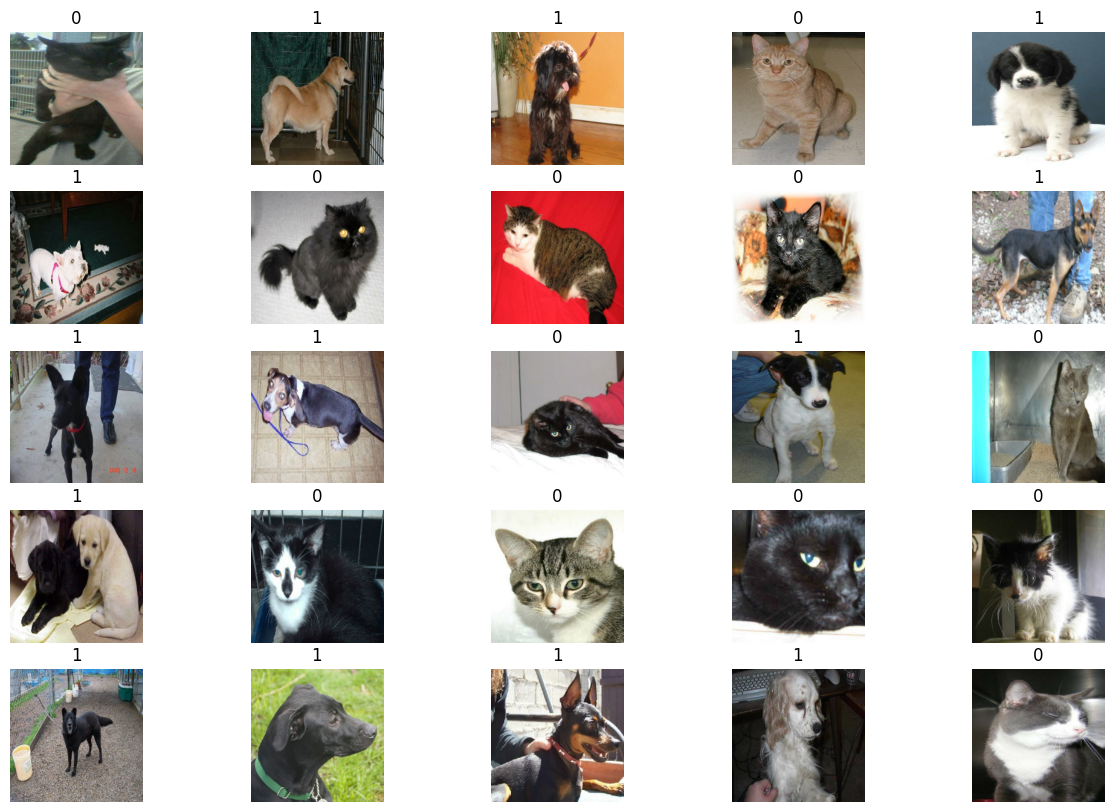

In [14]:
plt.figure(figsize=(15,10))
for image,label in test_data.take(1):
    for i in range(25):
        ax=plt.subplot(5,5,i+1)
        plt.imshow(np.array(image[i]).astype("uint8"))
        plt.title(int(label[i]))
        plt.axis("off")
    plt.show()

# Using image data augmentation

**When you don't have a large image dataset, it's a good practice to artificially introduce sample diversity by applying random yet realistic transformations to the training images, such as random horizontal flipping or small random rotations. This helps expose the model to different aspects of the training data while slowing down overfitting.**

In [15]:
data_augmentation=[layers.RandomFlip("horizontal"),layers.RandomRotation(0.1)]
def data_aug(images):
    for layer in data_augmentation:
        images=layer(images)
    return images

### Let's visualize what the augmented samples look like, by applying data_augmentation repeatedly to the first few images in the dataset:

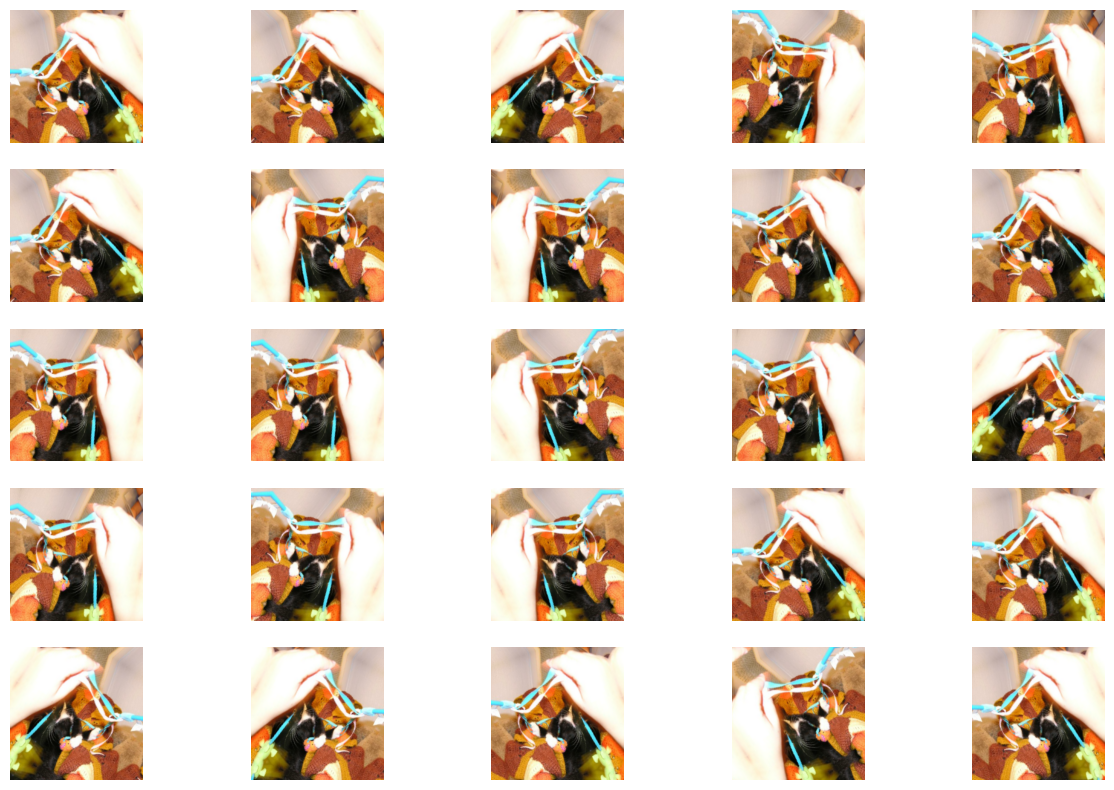

In [16]:
plt.figure(figsize=(15,10))
for image,_ in train_data.take(1):
    for i in range(25):
        augmented_image=data_aug(image)
        ax=plt.subplot(5,5,i+1)
        plt.imshow(np.array(augmented_image[0]).astype("uint8"))
        plt.axis("off")
    plt.show()

# Configure the dataset for performance

#### Let's apply data augmentation to our training dataset, and let's make sure to use buffered prefetching so we can yield data from disk without having I/O becoming blocking:

In [17]:
train_data=train_data.map(lambda image,label : (data_aug(image),label),num_parallel_calls=tf_data.AUTOTUNE)
train_data=train_data.prefetch(tf_data.AUTOTUNE)
valid_data=valid_data.prefetch(tf_data.AUTOTUNE)

# Build a model

#### We'll build a small version of the Xception network. We haven't particularly tried to optimize the architecture; if you want to do a systematic search for the best model configuration, consider using KerasTuner.

# Note that:

* 1.We start the model with the data_augmentation preprocessor, followed by a Rescaling layer.
* 2.We include a Dropout layer before the final classification layer.

In [18]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        units = 1
    else:
        units = num_classes

    x = layers.Dropout(0.25)(x)
    # We specify activation=None so as to return logits
    outputs = layers.Dense(units, activation=None)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
model.compile(optimizer=keras.optimizers.Adam(3e-4),loss=keras.losses.BinaryCrossentropy(from_logits=True),
                                                    metrics=[keras.metrics.BinaryAccuracy(name="binary_accuracy")])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 220, 220, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 220, 220, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 110, 110, 128)  │          3,584 │ rescaling[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 110, 110, 128)  │            512 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 110, 110, 128)  │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 110, 110, 128)  │              0 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv2d          │ (None, 110, 110, 256)  │         34,176 │ activation_1[0][0]     │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 110, 110, 256)  │          1,024 │ separable_conv2d[0][0] │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 110, 110, 256)  │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv2d_1        │ (None, 110, 110, 256)  │         68,096 │ activation_2[0][0]     │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 110, 110, 256)  │          1,024 │ separable_conv2d_1[0]… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 55, 55, 256)    │              0 │ batch_normalization_2… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 55, 55, 256)    │         33,024 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 55, 55, 256)    │              0 │ max_pooling2d[0][0],   │
│                           │                        │                │ conv2d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 55, 55, 256)    │              0 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv2d_2        │ (None, 55, 55, 512)    │        133,888 │ activation_3[0][0]     │
│ (SeparableConv2D)    

 Total params: 2,731,065 (10.42 MB)

 Trainable params: 2,722,777 (10.39 MB)

 Non-trainable params: 8,288 (32.38 KB)

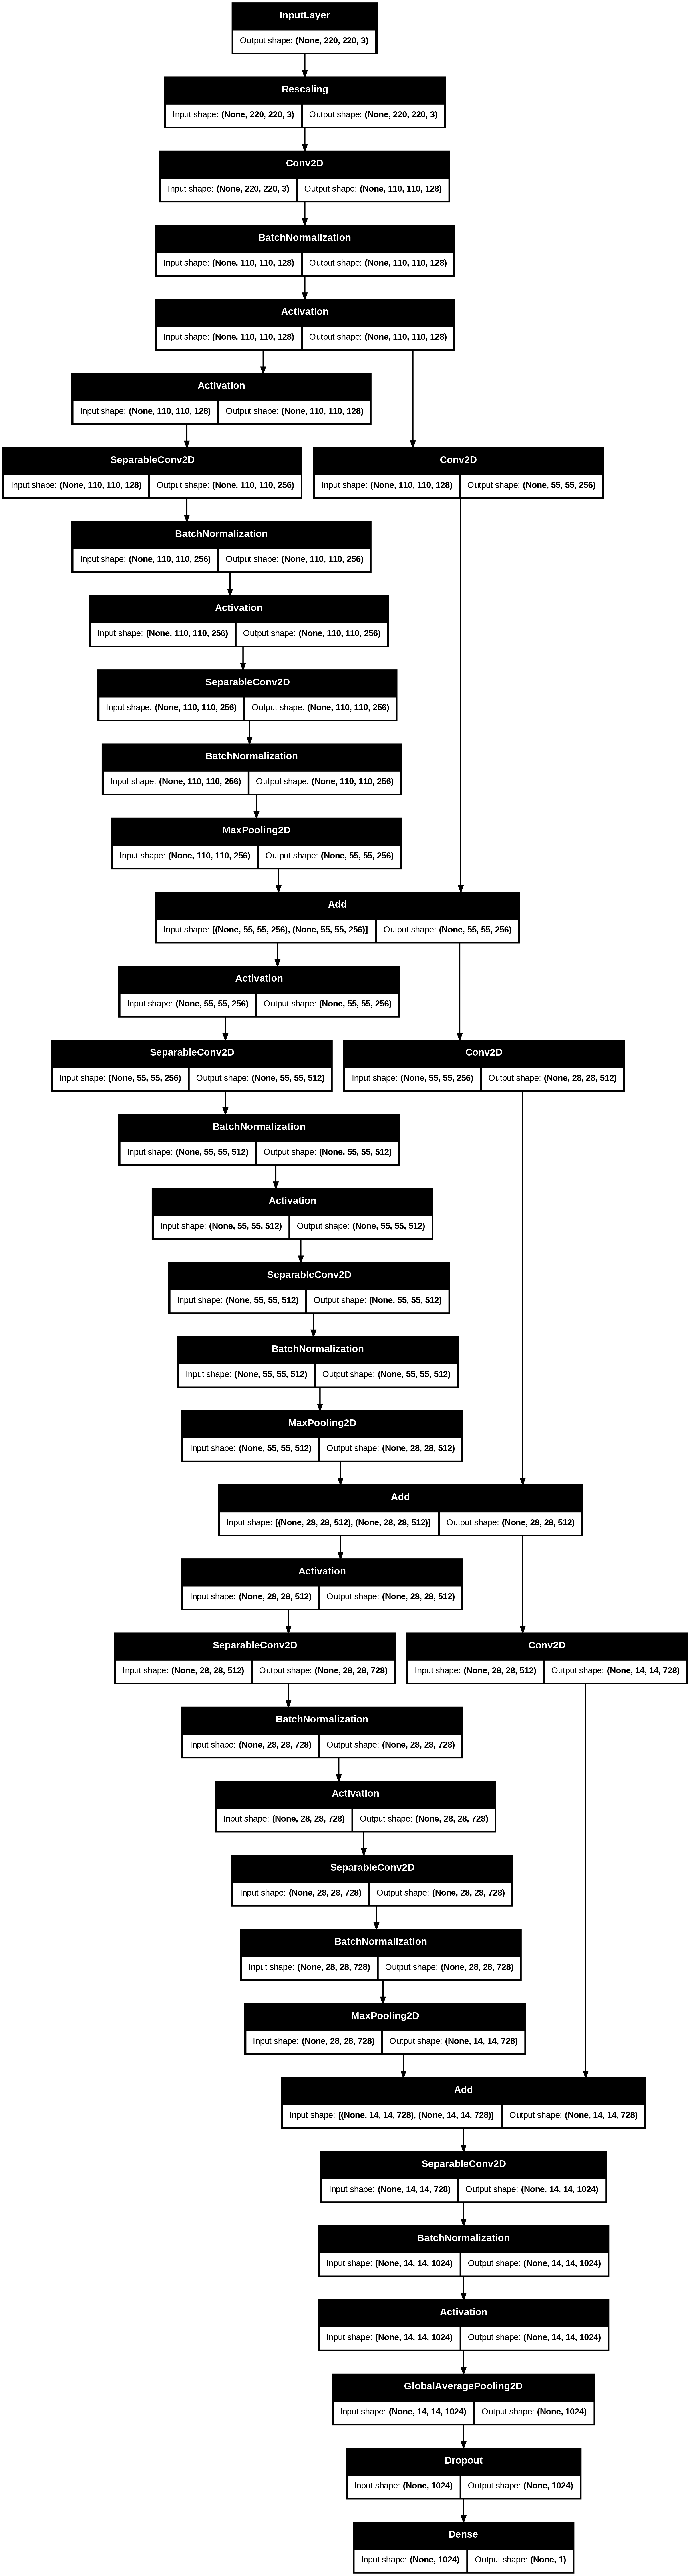

In [19]:
keras.utils.plot_model(model, show_shapes=True)

In [20]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
early_stopping = EarlyStopping(monitor='val_loss',patience=5,restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss',factor=0.5,patience=3,min_lr=1e-6)

In [21]:
epochs=10
history=model.fit(train_data,validation_data=valid_data,epochs=epochs,callbacks=[early_stopping, reduce_lr])

Epoch 1/10
513/513 ━━━━━━━━━━━━━━━━━━━━ 155s 247ms/step - binary_accuracy: 0.6252 - loss: 0.6488 - val_binary_accuracy: 0.4978 - val_loss: 1.0943 - learning_rate: 3.0000e-04
Epoch 2/10
513/513 ━━━━━━━━━━━━━━━━━━━━ 117s 228ms/step - binary_accuracy: 0.7632 - loss: 0.4690 - val_binary_accuracy: 0.7675 - val_loss: 0.4064 - learning_rate: 3.0000e-04
Epoch 3/10
513/513 ━━━━━━━━━━━━━━━━━━━━ 117s 227ms/step - binary_accuracy: 0.8263 - loss: 0.3628 - val_binary_accuracy: 0.8142 - val_loss: 0.3452 - learning_rate: 3.0000e-04
Epoch 4/10
513/513 ━━━━━━━━━━━━━━━━━━━━ 117s 227ms/step - binary_accuracy: 0.8681 - loss: 0.2939 - val_binary_accuracy: 0.8976 - val_loss: 0.2650 - learning_rate: 3.0000e-04
Epoch 5/10
513/513 ━━━━━━━━━━━━━━━━━━━━ 117s 228ms/step - binary_accuracy: 0.8842 - loss: 0.2610 - val_binary_accuracy: 0.8909 - val_loss: 0.3351 - learning_rate: 3.0000e-04
Epoch 6/10
513/513 ━━━━━━━━━━━━━━━━━━━━ 117s 227ms/step - binary_accuracy: 0.8945 - loss: 0.2391 - val_binary_accuracy: 0.8092 - v

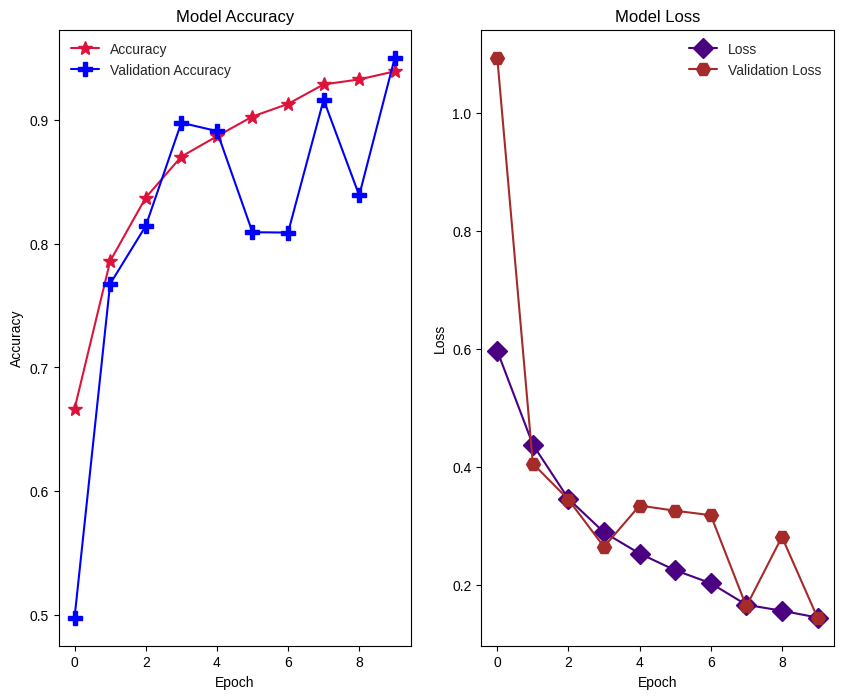

In [22]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,8))
plt.style.use("seaborn-v0_8-dark")
# First subplot
ax[0].plot(history.history['binary_accuracy'],label="Accuracy",color="crimson",marker="*",markersize=10)
ax[0].plot(history.history['val_binary_accuracy'],label="Validation Accuracy",color="blue",marker="P",markersize=10)
ax[0].set_title('Model Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(loc='best')

# Second subplot
ax[1].plot(history.history['loss'],label="Loss",color="indigo",marker="D",markersize=10)
ax[1].plot(history.history['val_loss'],label="Validation Loss",color="brown",marker="H",markersize=10)
ax[1].set_title('Model Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(loc='best')

plt.show()

# model Prediction

In [23]:
# Get the labels and predictions
y_true = []
y_pred = []


# Loop through the test data
for images, labels in test_data:
    # Get the ground truth labels
    y_true.extend(labels.numpy())
    
    # Get the predicted probabilities (from the sigmoid output)
    predictions = model.predict(images)

   
    
    # Apply threshold (0.5) to convert probabilities to class labels (0 or 1)
    y_pred.extend((predictions > 0.5).astype(int))  # Convert probabilities to binary labels

 
  

y_true = np.array(y_true)
y_pred = np.array(y_pred)



1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 876ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━

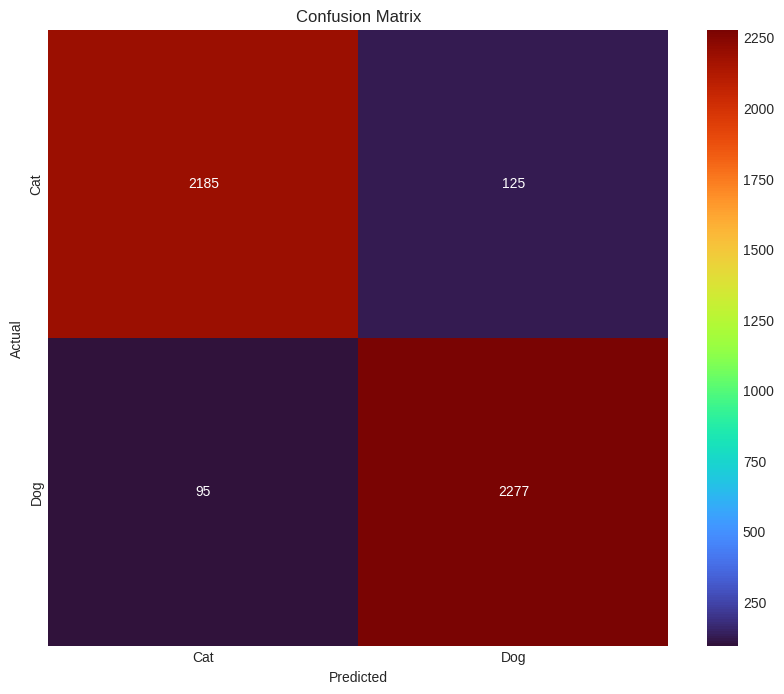

In [24]:
label_name=["Cat","Dog"]
cm = confusion_matrix(y_true,y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt="d", cmap="turbo", xticklabels=label_name, yticklabels=label_name)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [25]:
print(classification_report(y_true, y_pred, target_names=label_name))


              precision    recall  f1-score   support

         Cat       0.96      0.95      0.95      2310
         Dog       0.95      0.96      0.95      2372

    accuracy                           0.95      4682
   macro avg       0.95      0.95      0.95      4682
weighted avg       0.95      0.95      0.95      4682



In [26]:
print("="*100)
print("Accuracy:", accuracy_score(y_true, y_pred))
print("="*100)
print("Precision:", precision_score(y_true, y_pred))
print("="*100)
print("Recall:", recall_score(y_true, y_pred))
print("="*100)
print("F1 Score:", f1_score(y_true, y_pred))
print("="*100)
print("ROC AUC:", roc_auc_score(y_true, y_pred))
print("="*100)


Accuracy: 0.9530115335326783
Precision: 0.9479600333055787
Recall: 0.9599494097807757
F1 Score: 0.9539170506912442
ROC AUC: 0.9529184278341107


# roc curve

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━

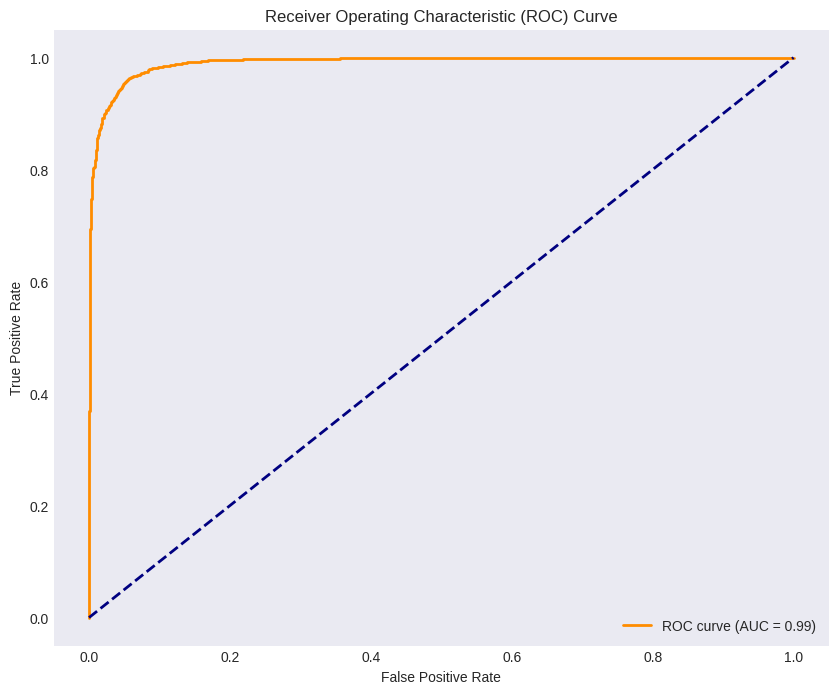

In [27]:

from sklearn.metrics import roc_curve, auc


y_true = []
y_prob = []

for images, labels in test_data:
    y_true.extend(labels.numpy())
    predictions = model.predict(images)
    y_prob.extend(predictions)

y_true = np.array(y_true)
y_prob = np.array(y_prob)

fpr, tpr, thresholds = roc_curve(y_true, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10,8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


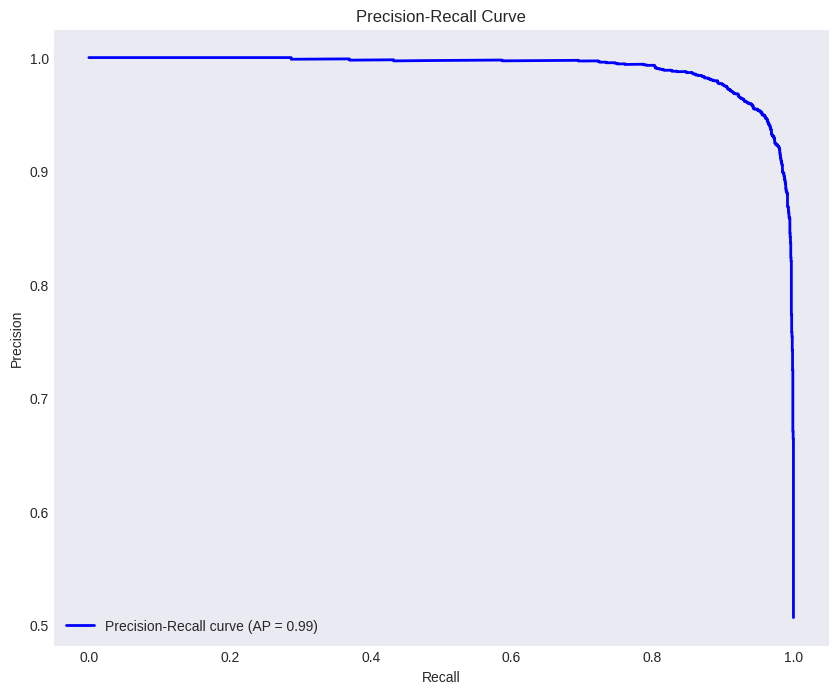

In [28]:
from sklearn.metrics import precision_recall_curve, average_precision_score

precision, recall, _ = precision_recall_curve(y_true, y_prob)
average_precision = average_precision_score(y_true, y_prob)

plt.figure(figsize=(10,8))
plt.plot(recall, precision, color='blue', lw=2, label=f'Precision-Recall curve (AP = {average_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()


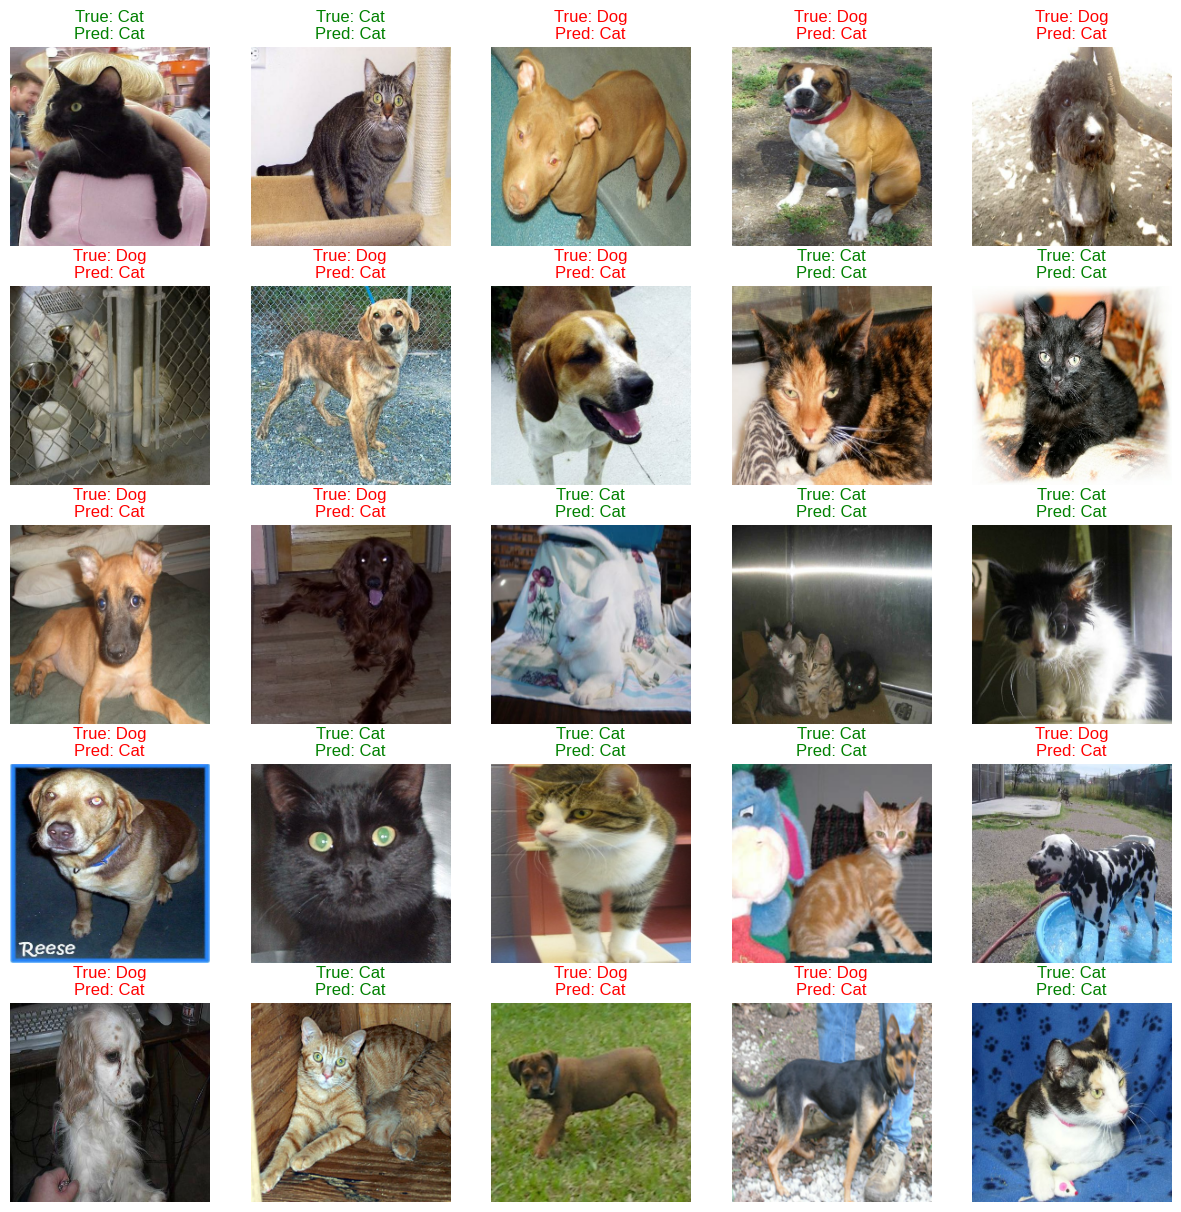

In [29]:


def predict_and_plot(model, test_data, label_names):
    for images, labels in test_data.take(1):
        predictions = model(images)
        predicted_labels = np.argmax(predictions.numpy(), axis=1)
        
        plt.figure(figsize=(15, 15))
        
        for i in range(min(len(images), 25)):
            ax = plt.subplot(5, 5, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            title = f"True: {label_names[labels[i]]}\nPred: {label_names[predicted_labels[i]]}"
            color = 'green' if labels[i] == predicted_labels[i] else 'red'
            ax.set_title(title, color=color)
            plt.axis("off")
        
        plt.show()

predict_and_plot(model, test_data, label_name)


# Run inference on new data
### Note that data augmentation and dropout are inactive at inference time.

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 855ms/step
This image is 77.06% cat and 22.94% dog.


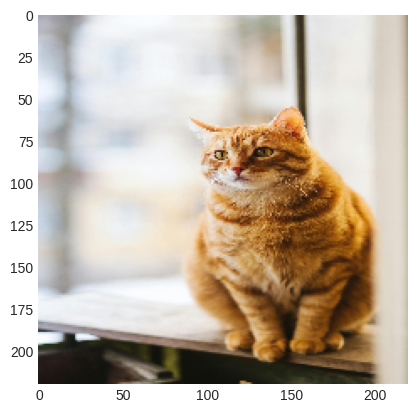

In [30]:
img = keras.utils.load_img("/kaggle/input/custom-image-dataset/cat.jpg", target_size=image_size)
plt.imshow(img)

img_array = keras.utils.img_to_array(img)
img_array = keras.ops.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = float(keras.ops.sigmoid(predictions[0][0]))
print(f"This image is {100 * (1 - score):.2f}% cat and {100 * score:.2f}% dog.")